In [1]:
import numpy as np
import pandas as pd

# visualization
from matplotlib import pyplot as plt
import altair as alt
import seaborn as sns

from stimuli import generate_sequence, encode_input, Dataset
from snn_params import Params
from snn_network import SNN

from util import load, save

In [9]:
plt.rcParams.update({'figure.figsize': (8, 6)})
plt.rcParams.update({'font.size': 14})

In [3]:
# Initialize parameters
parameters = Params()
print(parameters.sim["t"][0:10])

[0.    0.001 0.002 0.003 0.004 0.005 0.006 0.007 0.008 0.009]


### Input sequence

In [5]:
# Create full dataset
seq, rsp, out_seq = generate_sequence(possible_n_inner=np.arange(1, 5)+1, n_outer=350, seed=95)
inp = encode_input(sequence=seq)
print("AX: {} ({} %)".format(np.sum(out_seq=="AX"), round(np.sum(out_seq=="AX")/len(out_seq), 2)*100))
print("BY: {} ({} %)".format(np.sum(out_seq=="BY"), round(np.sum(out_seq=="BY")/len(out_seq), 2)*100))

AX: 373 (23.0 %)
BY: 381 (24.0 %)


1604


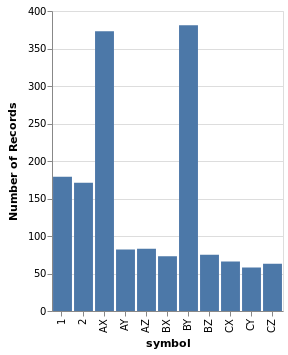

In [6]:
# Create dataframe for viz
df = pd.DataFrame(data=out_seq, columns=["symbol"])
print(len(out_seq))
# contruct a char

alt.Chart(data=df).mark_bar().encode(
    x="symbol",
    y="count()"
).interactive()


In [11]:
n_out = [25, 50, 100, 150, 200, 250, 300, 350]
n_in = [4, 5, 6, 8, 10]
pct = [[], [], [], [], []]

for k, j in enumerate(n_in):

    for i in n_out:

        seq, rsp, out_seq = generate_sequence(possible_n_inner=np.arange(1, j+1)+1, n_outer=i, seed=95)
        inp = encode_input(sequence=seq)
        dat = Dataset(sequence=seq, response=rsp, encoding=inp)

        t = dat.segment()
        pct[k].append((len(np.unique(t))/len(t)))

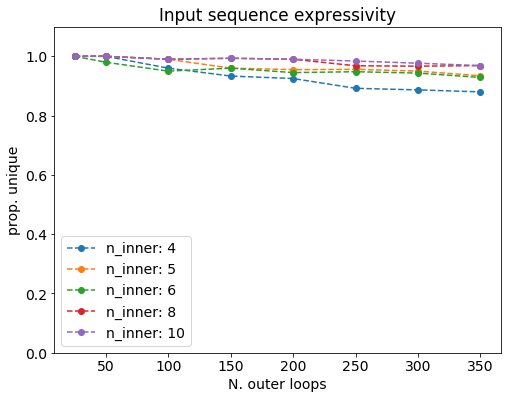

In [12]:
plt.figure()
for k, j in enumerate(n_in):

    plt.plot(np.array(n_out), np.array(pct[k]).T, '--o', label="n_inner: {}".format(j))
    plt.ylim(0, 1.1)
    plt.legend(loc="best")

plt.ylabel("prop. unique")
plt.xlabel("N. outer loops")
plt.title("Input sequence expressivity")
plt.show()

Create a shorter Pytorch dataset subclass

In [ ]:
# Use less trials
seq2, rsp2, out_seq2 = generate_sequence(n_inner=4, n_outer=2, seed=95)
print(seq2)
inp2 = encode_input(sequence=seq2)
print(inp2.shape)
ds2 = Dataset(sequence=seq2, response=rsp2, encoding=inp2)
print(ds2.encoding.shape)

### Network set up

In [ ]:
# Set up the network architecture and define parameters
net = SNN(params=parameters, n_neurons=1000, input_dim=8, output_dim=2)

net.config_input_weights(mean=0.4, density=0.5, seed=1)
net.config_recurrent_weights(density=0.1, ex=0.8, seed=2)
net.weight_scaling(input_scaling=2.1, recurrent_scaling=3.7e-9)

### Rate tuning

In [ ]:
df = pd.read_csv(filepath_or_buffer="/project/3011085.04/snn/data/interim/tuning_inputw.csv", header=0, index_col=0)
df.head()

In [ ]:
sns.catplot(data = df, x="scale", y="rate", color='black')

### Recurrent weights

In [ ]:
df = pd.read_csv(filepath_or_buffer="/project/3011085.04/snn/data/interim/tuning_recurrentw.csv", header=0)
alt.Chart(data=df).mark_point().encode(
    x="scale",
    y="mean_fr"
).interactive()

### Connectivity matrices

In [ ]:
plt.imshow(net.w["input"], aspect="auto", cmap="gray_r")
plt.title("Input weight matrix")
plt.ylabel("neuron nr.")
plt.xlabel("input symbol")
c = plt.colorbar()
c.set_label("Conductance")
plt.show()

In [ ]:
plt.imshow(net.w["recurrent"], aspect="auto")
plt.title("Recurrent weight matrix")
plt.ylabel("receiving neuron nr.")
plt.xlabel("sending neuron nr.")
c2 = plt.colorbar()
c2.set_label("Conductance")
plt.show()

In [ ]:
# Configure recording matrices

net.config_recording(n_neurons=net.neurons["N"], t=parameters.sim["t"], dataset=ds2, downsample=None)

# Create step current for input
step = parameters.step_current(t=net.recording["t_orig"], on=0.3, off=0.35, amp=4.4e-9)

In [ ]:
plt.plot(parameters.sim["t"], step)
plt.title("Input current")
plt.xlabel("time (sec)")
plt.ylabel("current (A)")
plt.show()

### Stimulate and record network responses

In [ ]:
# Train the network
net.train(dataset=ds2, current=step)

### Plot responses

In [ ]:
trial = 5
plt.imshow(net.recording["V"][trial,:,:], aspect="auto") # trial nr 1
plt.title("Membrane potential " + "(trial " + str(trial+1) + ")")
plt.xlabel("time (msec)")
plt.ylabel("neuron nr.")
c = plt.colorbar()
c.set_label("memb. potential (microV)")
plt.show()

In [ ]:
plt.plot(net.recording["V"][0,: , :].T)
plt.xlabel("Time (msec)")
plt.ylabel("Voltage (mV)")
plt.show()


In [ ]:
plt.imshow(net.recording["spikes"][1, :, :])
plt.title("Spikes " + "(trial " + str(trial+1) + ")")
plt.xlabel("time (msec)")
plt.ylabel("neuron nr")
plt.show()

## Classification analysis: Naive Bayes

#### Load data

In [ ]:
x = load("/project/3011085.04/snn/data/interim/average_states.pkl")
y = load("/project/3011085.04/snn/data/interim/responses.pkl")

In [ ]:
print(x.shape)

In [ ]:
plt.imshow(x.T, aspect="auto")
plt.xlabel("trial nr.")
plt.ylabel("neuron")
c = plt.colorbar()
c.set_label("Average memb. state (mV)")
plt.show()

In [ ]:
r = np.zeros(y.shape, dtype=int)
r[np.where(y),] = 1
print(r)

In [ ]:
print("Percent true: {}".format(round(np.sum(r)/len(r),2)))
print("Percent false: {} ".format(round((len(r)-np.sum(r))/len(r),2)))